PyTorch version: 2.1.2+cpu
CUDA available: False
Загрузка CIFAR-10 датасета...
Files already downloaded and verified
Files already downloaded and verified
Размер тренировочного набора: 50000
Размер тестового набора: 10000


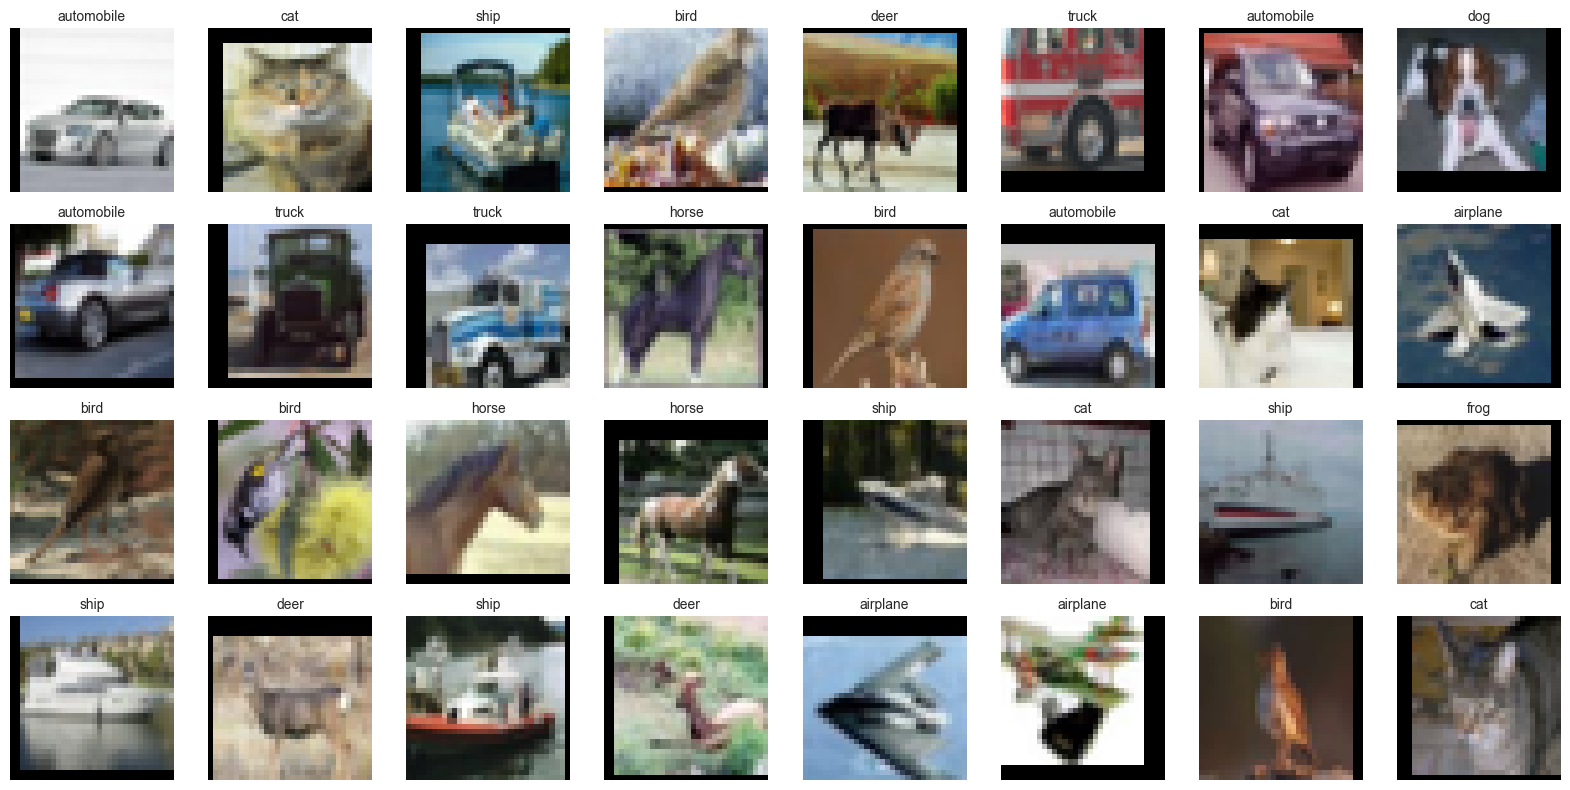

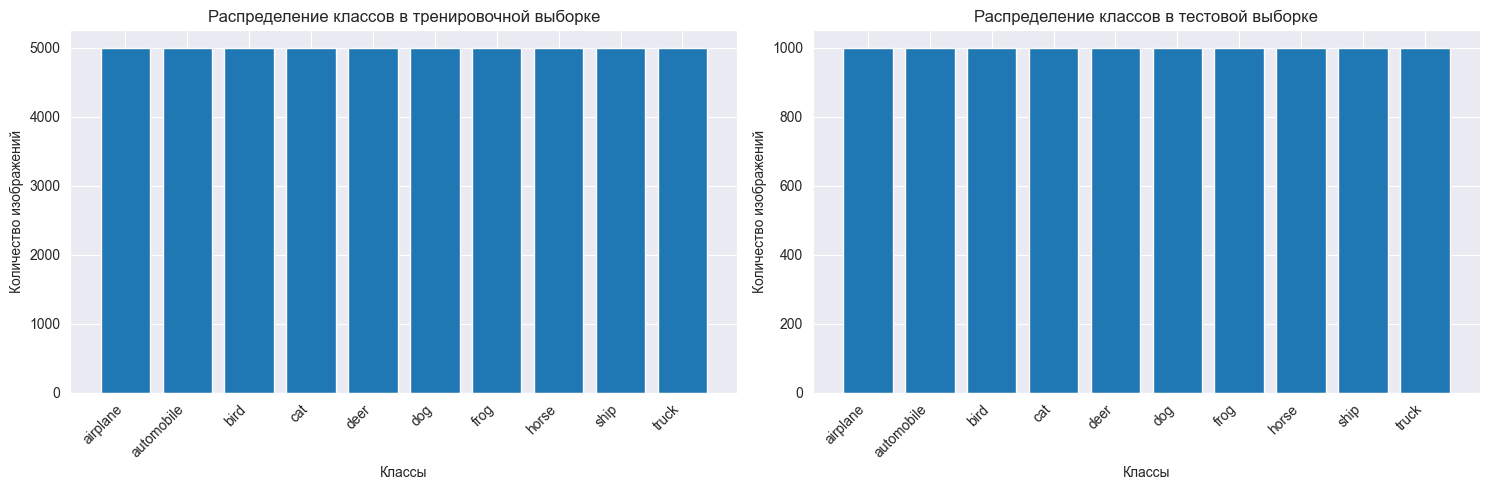

Размерность изображений: torch.Size([3, 32, 32])
SimpleCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=4096, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=10, bias=True)
  (dropout): Dropout(p=0.25, inplace=False)
  (relu): ReLU()
)
Начинаем обучение...
Epoch 1/10: Loss: 1.5248, Train Acc: 52.49%, Test Acc: 55.65%
Epoch 2/10: Loss: 1.2105, Train Acc: 58.21%, Test Acc: 61.32%
Epoch 3/10: Loss: 1.0763, Train Acc: 63.95%, Test Acc: 66.49%
Epoch 4/10: Loss: 0.9977, Train Acc: 63.75%, Test Acc: 66.79%
Epoch 5/10: Loss: 0.9444, Train Acc: 68.07%, Test Acc: 70.07%
Epoch 6/10: Loss: 0.9092, Train Acc: 69.36%, Test Acc: 71.06%
Epoch 7/10: Loss: 0.8753, Train Acc: 69.59%, Test Acc: 70.98%
Epoch 8/10: Loss: 0.8482, Train Acc: 71.19%, Test Acc: 72.17

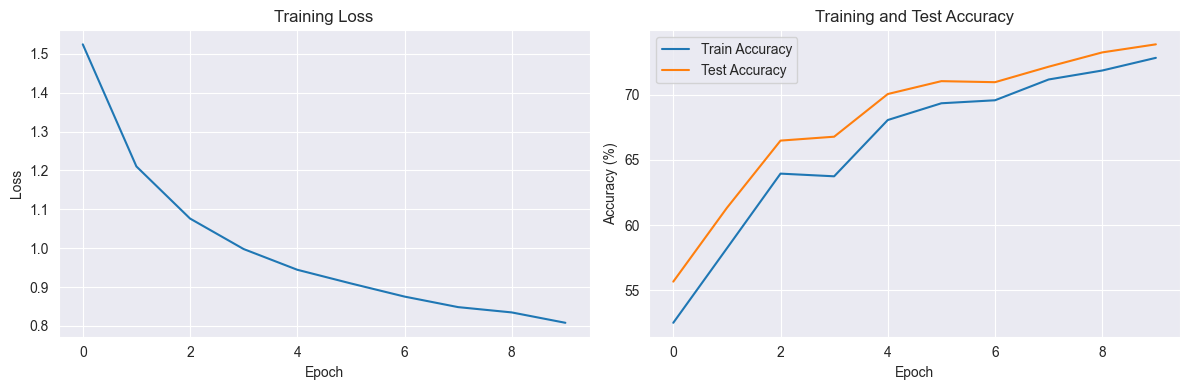

Финальная точность на тренировочных данных: 72.77%
Финальная точность на тестовых данных: 74.30%


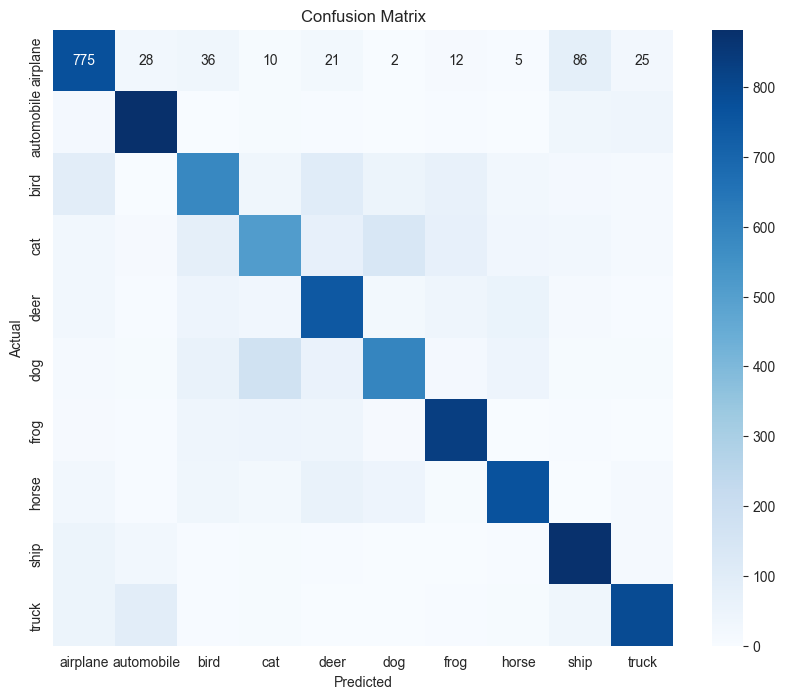


Classification Report:
              precision    recall  f1-score   support

    airplane       0.70      0.78      0.74      1000
  automobile       0.82      0.88      0.85      1000
        bird       0.65      0.58      0.61      1000
         cat       0.60      0.51      0.55      1000
        deer       0.67      0.74      0.70      1000
         dog       0.68      0.60      0.64      1000
        frog       0.78      0.83      0.80      1000
       horse       0.80      0.77      0.78      1000
        ship       0.78      0.88      0.83      1000
       truck       0.85      0.79      0.82      1000

    accuracy                           0.74     10000
   macro avg       0.73      0.74      0.73     10000
weighted avg       0.73      0.74      0.73     10000

Baseline модель сохранена в models/cifar10_baseline.pth
Названия классов сохранены в models/class_names.json


In [2]:
# %% [markdown]
# # Исследование CIFAR-10 датасета
# 
# ## Цели:
# - Загрузить и изучить данные
# - Визуализировать примеры изображений
# - Создать baseline модель
# - Оценить начальные метрики

# %%
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import confusion_matrix, classification_report

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

# %% [markdown]
# ## 1. Загрузка и предобработка данных

# %%
# Определяем трансформации для данных добавим аугментацию
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),      
    transforms.RandomCrop(32, padding=4),      
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Загружаем CIFAR-10, тест не агументируем
print("Загрузка CIFAR-10 датасета...")
trainset = torchvision.datasets.CIFAR10(
    root='./data', 
    train=True, 
    download=True, 
    transform=train_transform 
)
testset = torchvision.datasets.CIFAR10(
    root='./data', 
    train=False, 
    download=True, 
    transform=test_transform   
)

# Создаем DataLoader'ы
trainloader = DataLoader(trainset, batch_size=32, shuffle=True, num_workers=2)
testloader = DataLoader(testset, batch_size=32, shuffle=False, num_workers=2)

# Классы CIFAR-10
classes = ('airplane', 'automobile', 'bird', 'cat', 'deer', 
           'dog', 'frog', 'horse', 'ship', 'truck')

print(f"Размер тренировочного набора: {len(trainset)}")
print(f"Размер тестового набора: {len(testset)}")

# %% [markdown]
# ## 2. Визуализация данных

# %%
# Функция для отображения изображений
def imshow(img, ax=None):
    img = img / 2 + 0.5  # денормализация
    npimg = img.numpy()
    if ax is None:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))
    else:
        ax.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')

# Получаем несколько случайных тренировочных изображений
dataiter = iter(trainloader)
images, labels = next(dataiter)

# Показываем изображения
fig, axes = plt.subplots(4, 8, figsize=(16, 8))
axes = axes.ravel()
for i in range(32):
    imshow(images[i], axes[i])
    axes[i].set_title(classes[labels[i].item()], fontsize=10)
    axes[i].axis('off')  
    axes[i].set_aspect('equal')  

plt.tight_layout()
plt.show()

# %% [markdown]
# ## 3. Анализ распределения классов

# %%
# Собираем метки для анализа
train_labels = [label for _, label in trainset]
test_labels = [label for _, label in testset]

# Визуализируем распределение классов
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Тренировочные данные
train_counts = [train_labels.count(i) for i in range(10)]
bars1 = ax1.bar(range(10), train_counts)
ax1.set_title('Распределение классов в тренировочной выборке')
ax1.set_xlabel('Классы')
ax1.set_ylabel('Количество изображений')
ax1.set_xticks(range(10)) 
ax1.set_xticklabels(classes, rotation=45, ha='right')

# Тестовые данные
test_counts = [test_labels.count(i) for i in range(10)]
bars2 = ax2.bar(range(10), test_counts)
ax2.set_title('Распределение классов в тестовой выборке')
ax2.set_xlabel('Классы')
ax2.set_ylabel('Количество изображений')
ax2.set_xticks(range(10)) 
ax2.set_xticklabels(classes, rotation=45, ha='right')

plt.tight_layout()
plt.show()

print("Размерность изображений:", images[0].shape)

# %% [markdown]
# ## 4. Создание baseline модели

# %%
# Простая CNN модель на PyTorch
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)    
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 8 * 8, 512)
        self.fc2 = nn.Linear(512, 10)       
        self.dropout = nn.Dropout(0.25)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = x.view(-1, 64 * 8 * 8)
        x = self.dropout(self.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

# Создаем модель
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SimpleCNN().to(device)
print(model)

# %% [markdown]
# ## 5. Обучение baseline модели

# %%
# Функция для вычисления точности
def calculate_accuracy(loader, model):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in loader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return 100 * correct / total

# Обучение модели
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

train_losses = []
train_accuracies = []
test_accuracies = []

print("Начинаем обучение...")
for epoch in range(10):  # 10 эпох для baseline
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    # Вычисляем метрики после каждой эпохи
    epoch_loss = running_loss / len(trainloader)
    train_acc = calculate_accuracy(trainloader, model)
    test_acc = calculate_accuracy(testloader, model)
    
    train_losses.append(epoch_loss)
    train_accuracies.append(train_acc)
    test_accuracies.append(test_acc)
    
    print(f'Epoch {epoch+1}/10: Loss: {epoch_loss:.4f}, '
          f'Train Acc: {train_acc:.2f}%, Test Acc: {test_acc:.2f}%')

# %% [markdown]
# ## 6. Визуализация процесса обучения

# %%
# Графики обучения
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Loss
ax1.plot(train_losses)
ax1.set_title('Training Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')

# Accuracy
ax2.plot(train_accuracies, label='Train Accuracy')
ax2.plot(test_accuracies, label='Test Accuracy')
ax2.set_title('Training and Test Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy (%)')
ax2.legend()

plt.tight_layout()
plt.show()

# %% [markdown]
# ## 7. Оценка модели

# %%
# Финальная оценка
final_train_acc = calculate_accuracy(trainloader, model)
final_test_acc = calculate_accuracy(testloader, model)

print(f"Финальная точность на тренировочных данных: {final_train_acc:.2f}%")
print(f"Финальная точность на тестовых данных: {final_test_acc:.2f}%")

# Confusion Matrix
all_preds = []
all_labels = []
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=classes, yticklabels=classes)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Classification Report
print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=classes))

# %% [markdown]
# ## 8. Сохранение baseline модели

# %%
# Сохраняем модель для использования в API
torch.save(model.state_dict(), '../models/cifar10_baseline.pth')
print("Baseline модель сохранена в models/cifar10_baseline.pth")

# Сохраняем классы
import json
with open('../models/class_names.json', 'w') as f:
    json.dump(classes, f)
print("Названия классов сохранены в models/class_names.json")